Mon Nov 11 13:46:43 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+----------------------+
                                                                                         
+---------------------------------------------------------------------------------------+
| Processes:                                                                            |
|  GPU   GI   CI        PID   Type   Process name                            GPU Memory |
|        ID   ID                                                             Usage      |
|=======================================================================================|
|  No running processes found                                                           |
+---------------------------------------------------------------------------------------+

## Credit:

This notebook is based on a following tutorial on the https://curiousily.com website: https://curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/

In [1]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
#from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split

from torch import nn, optim

import torch.nn.functional as F
#from arff2pandas import a2p

import scipy
from scipy import io
import os
from pathlib import Path

import source.data_load_transform as dlt

In [2]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Verifica se 'mps' è disponibile su Apple Silicon

device = torch.device("mps" if torch.backends.mps.is_built() else "cpu")

 

# Conferma del dispositivo selezionato

print("Using device:", device)

Using device: mps




In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

    Read the tutorial
    Run the notebook in your browser (Google Colab)
    Read the Getting Things Done with Pytorch book

By the end of this tutorial, you'll learn how to:

    Prepare a dataset for Anomaly Detection from Time Series Data
    Build an LSTM Autoencoder with PyTorch
    Train and evaluate your model
    Choose a threshold for anomaly detection
    Classify unseen examples as normal or anomaly



### Data

The dataset contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

    An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. Source

We have 5 types of hearbeats (classes):

    Normal (N)
    R-on-T Premature Ventricular Contraction (R-on-T PVC)
    Premature Ventricular Contraction (PVC)
    Supra-ventricular Premature or Ectopic Beat (SP or EB)
    Unclassified Beat (UB).

    Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle. Frequency: 60–100 per minute (Humans) Duration: 0.6–1 second (Humans) Source

The dataset is available on my Google Drive. Let's get it:

In [3]:
os.listdir()

['.DS_Store',
 'requirements.txt',
 'Untitled.ipynb',
 'source',
 '.gitignore',
 'autoencoder_first_try.ipynb',
 '.ipynb_checkpoints',
 '.git',
 'autoencoder_tutorial.ipynb',
 'data']

In [4]:
os.getcwd()

'/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/project'

## Load Data and Sound Meta-Data:

### Define file_paths: 

In [5]:
root_path = Path('/Users/stephanehess/Documents/CAS_AML/autoencoder_timeseries_pytorch/project')
path_to_data = root_path/'data/MICRO_Motion_Capture/movement_data'
path_to_sound_meta_data = root_path/'data/MICRO_Motion_Capture/sound_data'

In [6]:
os.chdir(root_path)

In [7]:
os.chdir(path_to_data)

In [8]:
os.listdir()

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0007.tsv',
 'NM0012.tsv',
 'NM0006.tsv',
 'NM0010.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0011.tsv',
 'NM0008.tsv',
 'NM0009.tsv']

Get a list of all data files:

In [9]:
nm_files = os.listdir()
nm_files.sort()
nm_files

['NM0001.tsv',
 'NM0002.tsv',
 'NM0003.tsv',
 'NM0004.tsv',
 'NM0005.tsv',
 'NM0006.tsv',
 'NM0007.tsv',
 'NM0008.tsv',
 'NM0009.tsv',
 'NM0010.tsv',
 'NM0011.tsv',
 'NM0012.tsv']

In [10]:
#nm12raw = pd.read_csv('NM0012.tsv', delimiter='\t', encoding='utf-8', skiprows=10, low_memory=False)
#nm12raw.drop(nm12raw.columns[len(nm12raw.columns)-1], axis=1, inplace=True)

### Load all data into a dictionary (each entry is the data from one group of study participants:

In [11]:
nm_data_raw = dlt.load_data(nm_files)
len(nm_data_raw)
nm_data_raw.keys()

NM0001.tsv
1
NM0002.tsv
2
NM0003.tsv
3
NM0004.tsv
4
NM0005.tsv
5
NM0006.tsv
6
NM0007.tsv
7
NM0008.tsv
8
NM0009.tsv
9
NM0010.tsv
10
NM0011.tsv
11
NM0012.tsv
12


dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [12]:
for key, data in nm_data_raw.items():
    print(key)
    print(type(data))
    print(data.shape)

1
<class 'pandas.core.frame.DataFrame'>
(36000, 48)
2
<class 'pandas.core.frame.DataFrame'>
(36000, 33)
3
<class 'pandas.core.frame.DataFrame'>
(36000, 39)
4
<class 'pandas.core.frame.DataFrame'>
(36000, 45)
5
<class 'pandas.core.frame.DataFrame'>
(36000, 45)
6
<class 'pandas.core.frame.DataFrame'>
(36000, 36)
7
<class 'pandas.core.frame.DataFrame'>
(36000, 42)
8
<class 'pandas.core.frame.DataFrame'>
(36000, 21)
9
<class 'pandas.core.frame.DataFrame'>
(36000, 45)
10
<class 'pandas.core.frame.DataFrame'>
(36000, 36)
11
<class 'pandas.core.frame.DataFrame'>
(36000, 42)
12
<class 'pandas.core.frame.DataFrame'>
(36000, 15)


In [13]:
nm_data_raw.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

### Have a look:

In [14]:
nm_data_raw.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

In [15]:
nm_data_raw[2].head()

,S2 X,S2 Y,S2 Z,S5 X,S5 Y,S5 Z,S6 X,S6 Y,S6 Z,S8 X,...,S12 Z,Corner1 X,Corner1 Y,Corner1 Z,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z
0,-155.178,947.129,1876.783,-1101.584,163.179,1788.721,-163.050,137.777,1650.985,1441.440,...,1786.817,-1563.902,1551.982,1880.539,2165.307,1504.473,1859.317,2078.214,-1197.849,1874.806
1,-155.142,947.188,1876.791,-1101.592,163.268,1788.697,-163.045,137.846,1650.974,1441.220,...,1786.818,-1563.883,1551.958,1880.532,2165.418,1504.507,1859.353,2078.206,-1197.832,1874.801
2,-155.097,947.247,1876.817,-1101.606,163.376,1788.692,-163.032,137.934,1650.971,1441.215,...,1786.628,-1563.892,1551.960,1880.528,2165.418,1504.507,1859.353,2078.182,-1197.823,1874.771
3,-155.033,947.247,1876.843,-1101.561,163.401,1788.626,-162.996,138.018,1650.963,1441.301,...,1786.544,-1563.909,1551.990,1880.544,2165.529,1504.451,1859.399,2078.138,-1197.883,1874.840
4,-155.016,947.301,1876.841,-1101.584,163.514,1788.640,-162.980,138.112,1650.945,1441.296,...,1786.610,-1563.906,1551.985,1880.548,2165.446,1504.441,1859.359,2078.127,-1197.890,1874.852


In [16]:
nm_data_raw[1].shape

(36000, 48)

In [17]:
nm_data_raw[1].columns

Index(['S1 X', 'S1 Y', 'S1 Z', 'S2 X', 'S2 Y', 'S2 Z', 'S3 X', 'S3 Y', 'S3 Z',
       'S4 X', 'S4 Y', 'S4 Z', 'S5 X', 'S5 Y', 'S5 Z', 'S6 X', 'S6 Y', 'S6 Z',
       'S7 X', 'S7 Y', 'S7 Z', 'S8 X', 'S8 Y', 'S8 Z', 'S9 X', 'S9 Y', 'S9 Z',
       'S10 X', 'S10 Y', 'S10 Z', 'S11 X', 'S11 Y', 'S11 Z', 'S12 X', 'S12 Y',
       'S12 Z', 'Corner1 X', 'Corner1 Y', 'Corner1 Z', 'Corner2 X',
       'Corner2 Y', 'Corner2 Z', 'Corner3 X', 'Corner3 Y', 'Corner3 Z',
       'Corner4 X', 'Corner4 Y', 'Corner4 Z'],
      dtype='object')

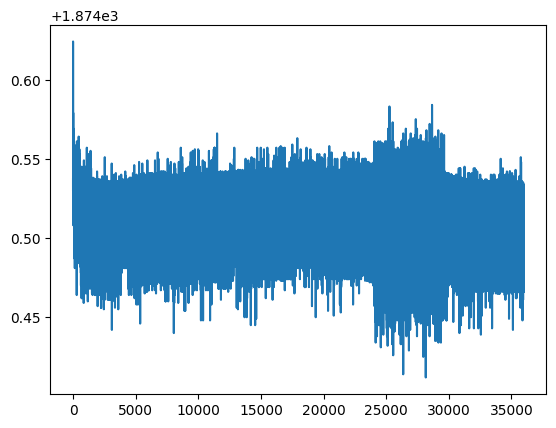

In [18]:
plt.plot(nm_data_raw[1]['Corner3 Z'])

### Load sound meta-data (order of songs for each group of study participants:

In [19]:
os.chdir(path_to_sound_meta_data)

In [20]:
song_order = pd.read_csv('nm15_song_order.csv')
song_order

,1,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [21]:
song_order.shape

(12, 5)

In [22]:
song_order.columns = ['groups', 2, 3, 4, 5]
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


In [23]:
song_order

,groups,2,3,4,5
0,A,3,1,2,4
1,B,1,2,4,3
2,C,1,2,3,4
3,D,2,3,4,1
4,E,1,2,3,4
5,F,3,1,2,4
6,G,3,2,4,1
7,H,3,2,4,1
8,I,3,1,2,4
9,J,3,4,2,1


Add a column of 1 (silence sound track) at the beginning and at the end of the data frame because each experiment started and ended with one minute of silence:

In [24]:
first_minute = [int(1)]*song_order.shape[0]
last_minute = [int(1)]*song_order.shape[0]

In [25]:
song_order.insert(1, 1, first_minute)
song_order.insert(song_order.shape[1], 6, last_minute)
song_order

,groups,1,2,3,4,5,6
0,A,1,3,1,2,4,1
1,B,1,1,2,4,3,1
2,C,1,1,2,3,4,1
3,D,1,2,3,4,1,1
4,E,1,1,2,3,4,1
5,F,1,3,1,2,4,1
6,G,1,3,2,4,1,1
7,H,1,3,2,4,1,1
8,I,1,3,1,2,4,1
9,J,1,3,4,2,1,1


Replace the letters that designate the experimental groups with numbers:

In [26]:
song_order.groups = list(range(1,13))
song_order

,groups,1,2,3,4,5,6
0,1,1,3,1,2,4,1
1,2,1,1,2,4,3,1
2,3,1,1,2,3,4,1
3,4,1,2,3,4,1,1
4,5,1,1,2,3,4,1
5,6,1,3,1,2,4,1
6,7,1,3,2,4,1,1
7,8,1,3,2,4,1,1
8,9,1,3,1,2,4,1
9,10,1,3,4,2,1,1


### Attribute sound track number to the time series data:

In [27]:
nm_data_labelled = dlt.attribute_sound_track_labels(song_order, nm_data_raw)

In [28]:
nm_data_labelled[1].head()

,S1 X,S1 Y,S1 Z,S2 X,S2 Y,S2 Z,S3 X,S3 Y,S3 Z,S4 X,...,Corner2 X,Corner2 Y,Corner2 Z,Corner3 X,Corner3 Y,Corner3 Z,Corner4 X,Corner4 Y,Corner4 Z,target
0,-1132.908,1053.272,1738.612,-577.677,983.700,1680.741,319.148,1002.059,1793.367,1323.212,...,2164.907,1504.309,1859.115,2079.816,-1237.564,1874.537,-1678.877,-1008.469,1870.884,1
1,-1132.979,1053.367,1738.614,-577.466,983.874,1680.804,319.131,1001.943,1793.363,1321.374,...,2164.909,1504.296,1859.115,2079.834,-1237.573,1874.530,-1678.953,-1008.503,1870.912,1
2,-1133.041,1053.458,1738.627,-577.294,984.055,1680.878,319.120,1001.800,1793.369,1321.383,...,2164.942,1504.317,1859.114,2079.857,-1237.581,1874.560,-1678.953,-1008.503,1870.912,1
3,-1133.070,1053.473,1738.604,-577.121,984.249,1680.953,319.087,1001.616,1793.341,1321.124,...,2164.932,1504.229,1859.118,2079.720,-1237.606,1874.586,-1678.955,-1008.444,1870.999,1
4,-1133.117,1053.564,1738.602,-576.947,984.451,1680.971,319.006,1001.445,1793.341,1321.112,...,2164.930,1504.208,1859.116,2079.818,-1237.633,1874.624,-1678.955,-1008.444,1870.999,1


### Remove the Corner columns from the data:

In [29]:
dlt.choose_columns_no_corner(nm_data_labelled)

In [30]:
nm_data_labelled[1].head()

,S1 X,S1 Y,S1 Z,S2 X,S2 Y,S2 Z,S3 X,S3 Y,S3 Z,S4 X,...,S10 X,S10 Y,S10 Z,S11 X,S11 Y,S11 Z,S12 X,S12 Y,S12 Z,target
0,-1132.908,1053.272,1738.612,-577.677,983.700,1680.741,319.148,1002.059,1793.367,1323.212,...,-313.999,-743.250,1746.861,518.993,-771.930,1608.487,1350.808,-733.394,1656.141,1
1,-1132.979,1053.367,1738.614,-577.466,983.874,1680.804,319.131,1001.943,1793.363,1321.374,...,-314.005,-743.303,1746.845,519.038,-771.953,1608.491,1350.901,-733.359,1656.094,1
2,-1133.041,1053.458,1738.627,-577.294,984.055,1680.878,319.120,1001.800,1793.369,1321.383,...,-314.042,-743.342,1746.848,519.087,-771.909,1608.505,1350.980,-733.321,1656.162,1
3,-1133.070,1053.473,1738.604,-577.121,984.249,1680.953,319.087,1001.616,1793.341,1321.124,...,-314.076,-743.345,1746.832,519.123,-771.866,1608.656,1350.993,-733.236,1656.191,1
4,-1133.117,1053.564,1738.602,-576.947,984.451,1680.971,319.006,1001.445,1793.341,1321.112,...,-314.057,-743.430,1746.816,519.165,-771.854,1608.639,1351.058,-733.186,1656.183,1


## Take all data from sound track silence and put them into one data frame:

In [31]:
CLASS_NORMAL = 1

Check for missing values:

In [32]:
nan_columns = {} 
for name, df in nm_data_labelled.items(): 
    nan_cols = df.columns[df.isna().all()].tolist() 
    nan_columns[name] = nan_cols

In [33]:
nan_columns[name]

[]

Take all the data with label CLASS_NORMAL: 

In [34]:
normal_data_all_1d = dlt.take_data_with_label_or_not(nm_data_labelled, CLASS_NORMAL)

#normal_data_all_1d = dlt.take_data_with_label_or_not(nm_data_try, CLASS_NORMAL)

(18000, 13)
(18000, 9)
(18000, 11)
(18000, 13)
(18000, 12)
(18000, 9)
(18000, 11)
(18000, 4)
(18000, 12)
(18000, 9)
(18000, 13)
(18000, 4)


In [35]:
type(normal_data_all_1d)

dict

In [36]:
for key, item in normal_data_all_1d.items():
    print(set(item.target))

{1}
{1}
{1}
{1}
{1}
{1}
{1}
{1}
{1}
{1}
{1}
{1}


Take data from the dictionary, transpose them and put them into a dataframe:

Transpose the data frame by sound track length (each batch of data corresponding to one sound track has to be transposed individually because one row should contain the time series corresponding to one sound track:

In [37]:
normal_data_all_1d_t = dlt.transpose_into_dataframe(normal_data_all_1d)

1
2
3
4
5
6
7
8
9
10
11
12


In [38]:
normal_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
S1 X,-1132.908,-1132.979,-1133.041,-1133.070,-1133.117,-1133.110,-1133.115,-1133.159,-1133.185,-1133.216,...,-1134.635,-1134.727,-1134.805,-1134.750,-1134.856,-1135.040,-1135.126,-1135.225,-1135.317,1
S2 X,-577.677,-577.466,-577.294,-577.121,-576.947,-576.829,-576.828,-576.588,-576.494,-576.402,...,-581.390,-581.369,-581.332,-581.302,-581.301,-581.279,-581.257,-581.229,-581.209,1
S3 X,319.148,319.131,319.120,319.087,319.006,318.800,318.751,318.674,318.550,318.401,...,337.249,337.285,337.288,337.322,337.337,337.329,337.352,337.352,337.349,1
S4 X,1323.212,1321.374,1321.383,1321.124,1321.112,1321.037,1321.344,1320.960,1320.915,1320.860,...,1312.038,1312.052,1312.065,1312.058,1312.050,1312.061,1312.082,1312.071,1312.074,1
S5 X,-1184.425,-1184.403,-1184.367,-1184.307,-1184.249,-1184.142,-1184.196,-1184.157,-1184.111,-1184.065,...,-1182.208,-1182.184,-1182.161,-1182.127,-1182.110,-1182.094,-1182.065,-1182.046,-1182.023,1


### Reset the index and make a column with the person id:

In [39]:
normal_data_all_1d_t.reset_index(inplace=True, drop=False, names='person')

In [40]:
normal_data_all_1d_t.head(30)

,person,0,1,2,3,4,5,6,7,8,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
0,S1 X,-1132.908,-1132.979,-1133.041,-1133.070,-1133.117,-1133.110,-1133.115,-1133.159,-1133.185,...,-1134.635,-1134.727,-1134.805,-1134.750,-1134.856,-1135.040,-1135.126,-1135.225,-1135.317,1
1,S2 X,-577.677,-577.466,-577.294,-577.121,-576.947,-576.829,-576.828,-576.588,-576.494,...,-581.390,-581.369,-581.332,-581.302,-581.301,-581.279,-581.257,-581.229,-581.209,1
2,S3 X,319.148,319.131,319.120,319.087,319.006,318.800,318.751,318.674,318.550,...,337.249,337.285,337.288,337.322,337.337,337.329,337.352,337.352,337.349,1
3,S4 X,1323.212,1321.374,1321.383,1321.124,1321.112,1321.037,1321.344,1320.960,1320.915,...,1312.038,1312.052,1312.065,1312.058,1312.050,1312.061,1312.082,1312.071,1312.074,1
4,S5 X,-1184.425,-1184.403,-1184.367,-1184.307,-1184.249,-1184.142,-1184.196,-1184.157,-1184.111,...,-1182.208,-1182.184,-1182.161,-1182.127,-1182.110,-1182.094,-1182.065,-1182.046,-1182.023,1
5,S6 X,-327.140,-326.955,-326.757,-326.536,-326.348,-326.131,-325.949,-325.892,-325.778,...,-328.541,-328.514,-328.518,-328.516,-328.506,-328.506,-328.510,-328.536,-328.539,1
6,S7 X,522.711,522.756,522.773,522.807,522.831,522.829,522.815,522.802,522.787,...,534.452,534.469,534.487,534.521,534.536,534.568,534.615,534.685,534.731,1
7,S8 X,1334.210,1334.231,1334.269,1334.260,1334.267,1334.331,1334.329,1334.054,1334.034,...,1302.935,1303.036,1303.099,1303.228,1303.349,1303.466,1303.598,1303.709,1303.826,1
8,S9 X,-1283.543,-1283.653,-1283.615,-1283.641,-1283.600,-1283.571,-1283.355,-1283.313,-1283.203,...,-1270.457,-1270.404,-1270.375,-1270.350,-1270.344,-1270.407,-1270.344,-1270.355,-1270.401,1
9,S10 X,-313.999,-314.005,-314.042,-314.076,-314.057,-314.038,-313.868,-313.810,-313.805,...,-325.372,-325.418,-325.428,-325.439,-325.458,-325.467,-325.462,-325.489,-325.494,1


In [41]:
normal_data_all_1d_t.columns

Index([  'person',          0,          1,          2,          3,          4,
                5,          6,          7,          8,
       ...
             5991,       5992,       5993,       5994,       5995,       5996,
             5997,       5998,       5999, 'group_id'],
      dtype='object', length=6002)

In [42]:
normal_data_all_1d_t.shape

(324, 6002)

### Take a small part of the data for quicker training:

In [49]:
normal_data_all_1d_t.iloc[:,0:1].shape

(324, 1)

In [47]:
normal_data_all_1d_t.iloc[:,-600:].shape

(324, 600)

In [57]:
normal_data_all_1d_t = pd.concat([normal_data_all_1d_t.iloc[:,0:1], normal_data_all_1d_t.iloc[:,-600:]], axis=1)

In [58]:
normal_data_all_1d_t.head()

,person,5401,5402,5403,5404,5405,5406,5407,5408,5409,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
0,S1 X,-1142.621,-1142.666,-1142.721,-1142.761,-1142.782,-1142.814,-1142.823,-1142.818,-1142.809,...,-1134.635,-1134.727,-1134.805,-1134.750,-1134.856,-1135.040,-1135.126,-1135.225,-1135.317,1
1,S2 X,-579.147,-579.210,-579.274,-579.368,-579.447,-579.577,-579.664,-579.753,-579.839,...,-581.390,-581.369,-581.332,-581.302,-581.301,-581.279,-581.257,-581.229,-581.209,1
2,S3 X,333.943,333.974,334.040,334.146,334.228,334.288,334.366,334.404,334.453,...,337.249,337.285,337.288,337.322,337.337,337.329,337.352,337.352,337.349,1
3,S4 X,1315.507,1315.490,1315.539,1315.585,1315.571,1315.629,1315.667,1315.696,1315.703,...,1312.038,1312.052,1312.065,1312.058,1312.050,1312.061,1312.082,1312.071,1312.074,1
4,S5 X,-1185.159,-1185.139,-1185.101,-1185.072,-1185.049,-1185.021,-1185.010,-1185.005,-1185.024,...,-1182.208,-1182.184,-1182.161,-1182.127,-1182.110,-1182.094,-1182.065,-1182.046,-1182.023,1


In [59]:
normal_data_all_1d_t.shape

(324, 601)

## Take all data from music sound tracks and put them into one data frame:

Take all data except those with CLASS_NORMAL:

In [60]:

#anomaly_data_all_1d = dlt.take_data_with_label_or_not(nm_data_try, CLASS_NORMAL, with_label=bbFalse)

anomaly_data_all_1d = dlt.take_data_with_label_or_not(nm_data_labelled, CLASS_NORMAL, with_label=False)

(18000, 13)
(18000, 9)
(18000, 11)
(18000, 13)
(18000, 12)
(18000, 9)
(18000, 11)
(18000, 4)
(18000, 12)
(18000, 9)
(18000, 13)
(18000, 4)


In [61]:
type(anomaly_data_all_1d)

dict

In [62]:
for key, item in anomaly_data_all_1d.items():
    print(set(item.target))

{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}
{2, 3, 4}


Take data from the dictionary, transpose them and put them into a dataframe:

In [63]:
anomaly_data_all_1d_t = dlt.transpose_into_dataframe(anomaly_data_all_1d)

1
2
3
4
5
6
7
8
9
10
11
12


In [64]:
anomaly_data_all_1d_t.head()

,0,1,2,3,4,5,6,7,8,9,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
S1 X,-1135.417,-1135.517,-1135.610,-1135.689,-1135.736,-1135.798,-1135.838,-1135.877,-1135.884,-1135.881,...,-1127.288,-1127.306,-1127.346,-1127.385,-1127.435,-1127.498,-1127.554,-1127.608,-1127.691,1
S2 X,-581.169,-581.145,-581.119,-581.093,-581.071,-581.058,-581.044,-581.027,-580.969,-580.919,...,-590.033,-590.015,-589.993,-589.988,-589.989,-589.981,-589.991,-590.006,-590.014,1
S3 X,337.342,337.331,337.333,337.350,337.347,337.385,337.418,337.496,337.573,337.663,...,331.833,331.777,331.721,331.691,331.628,331.565,331.568,331.535,331.528,1
S4 X,1312.071,1312.096,1312.137,1312.185,1312.176,1312.221,1312.261,1312.326,1312.366,1312.404,...,1309.984,1310.026,1310.019,1310.031,1310.042,1310.034,1310.040,1310.037,1310.041,1
S5 X,-1182.022,-1182.018,-1182.009,-1182.007,-1182.003,-1182.020,-1182.031,-1182.038,-1182.043,-1182.041,...,-1183.188,-1183.122,-1183.035,-1182.977,-1182.933,-1182.869,-1182.825,-1182.798,-1182.754,1


### Reset the index and make a column with the person id:

In [65]:
anomaly_data_all_1d_t.reset_index(inplace=True, drop=False, names='person')

In [66]:
anomaly_data_all_1d_t.head(30)

,person,0,1,2,3,4,5,6,7,8,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
0,S1 X,-1135.417,-1135.517,-1135.610,-1135.689,-1135.736,-1135.798,-1135.838,-1135.877,-1135.884,...,-1127.288,-1127.306,-1127.346,-1127.385,-1127.435,-1127.498,-1127.554,-1127.608,-1127.691,1
1,S2 X,-581.169,-581.145,-581.119,-581.093,-581.071,-581.058,-581.044,-581.027,-580.969,...,-590.033,-590.015,-589.993,-589.988,-589.989,-589.981,-589.991,-590.006,-590.014,1
2,S3 X,337.342,337.331,337.333,337.350,337.347,337.385,337.418,337.496,337.573,...,331.833,331.777,331.721,331.691,331.628,331.565,331.568,331.535,331.528,1
3,S4 X,1312.071,1312.096,1312.137,1312.185,1312.176,1312.221,1312.261,1312.326,1312.366,...,1309.984,1310.026,1310.019,1310.031,1310.042,1310.034,1310.040,1310.037,1310.041,1
4,S5 X,-1182.022,-1182.018,-1182.009,-1182.007,-1182.003,-1182.020,-1182.031,-1182.038,-1182.043,...,-1183.188,-1183.122,-1183.035,-1182.977,-1182.933,-1182.869,-1182.825,-1182.798,-1182.754,1
5,S6 X,-328.498,-328.457,-328.433,-328.402,-328.384,-328.392,-328.431,-328.448,-328.506,...,-336.138,-336.096,-336.027,-335.916,-335.839,-335.746,-335.593,-335.483,-335.361,1
6,S7 X,534.816,534.877,534.960,535.081,535.169,535.265,535.299,535.339,535.350,...,543.491,543.487,543.486,543.469,543.485,543.474,543.513,543.519,543.532,1
7,S8 X,1303.885,1303.979,1304.035,1304.093,1304.146,1304.199,1304.247,1304.298,1304.356,...,1288.755,1288.751,1288.763,1288.784,1288.754,1288.774,1288.807,1288.802,1288.833,1
8,S9 X,-1270.408,-1270.378,-1270.366,-1270.462,-1270.358,-1270.345,-1270.453,-1270.357,-1270.328,...,-1269.455,-1269.429,-1269.482,-1269.475,-1269.520,-1269.569,-1269.594,-1269.617,-1269.658,1
9,S10 X,-325.499,-325.472,-325.472,-325.476,-325.436,-325.396,-325.395,-325.381,-325.370,...,-326.326,-326.349,-326.350,-326.364,-326.404,-326.390,-326.410,-326.412,-326.437,1


### Take a small part of the data for quicker training:

In [67]:
anomaly_data_all_1d_t = pd.concat([anomaly_data_all_1d_t.iloc[:,0:1], anomaly_data_all_1d_t.iloc[:,-600:]], axis=1)

In [68]:
anomaly_data_all_1d_t.head()

,person,5401,5402,5403,5404,5405,5406,5407,5408,5409,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
0,S1 X,-1131.162,-1131.155,-1131.101,-1131.068,-1131.030,-1131.001,-1130.950,-1130.915,-1130.860,...,-1127.288,-1127.306,-1127.346,-1127.385,-1127.435,-1127.498,-1127.554,-1127.608,-1127.691,1
1,S2 X,-586.788,-586.794,-586.808,-586.824,-586.824,-586.825,-586.831,-586.810,-586.793,...,-590.033,-590.015,-589.993,-589.988,-589.989,-589.981,-589.991,-590.006,-590.014,1
2,S3 X,333.003,332.947,332.875,332.815,332.755,332.717,332.664,332.643,332.644,...,331.833,331.777,331.721,331.691,331.628,331.565,331.568,331.535,331.528,1
3,S4 X,1312.024,1312.096,1312.120,1312.156,1312.223,1312.248,1312.281,1312.325,1312.365,...,1309.984,1310.026,1310.019,1310.031,1310.042,1310.034,1310.040,1310.037,1310.041,1
4,S5 X,-1182.840,-1182.842,-1182.857,-1182.851,-1182.858,-1182.855,-1182.841,-1182.807,-1182.763,...,-1183.188,-1183.122,-1183.035,-1182.977,-1182.933,-1182.869,-1182.825,-1182.798,-1182.754,1


In [69]:
anomaly_data_all_1d_t.shape

(324, 601)

## Exploratory Data Analysis


In [70]:
anomaly_data_all_1d_t.head()

,person,5401,5402,5403,5404,5405,5406,5407,5408,5409,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
0,S1 X,-1131.162,-1131.155,-1131.101,-1131.068,-1131.030,-1131.001,-1130.950,-1130.915,-1130.860,...,-1127.288,-1127.306,-1127.346,-1127.385,-1127.435,-1127.498,-1127.554,-1127.608,-1127.691,1
1,S2 X,-586.788,-586.794,-586.808,-586.824,-586.824,-586.825,-586.831,-586.810,-586.793,...,-590.033,-590.015,-589.993,-589.988,-589.989,-589.981,-589.991,-590.006,-590.014,1
2,S3 X,333.003,332.947,332.875,332.815,332.755,332.717,332.664,332.643,332.644,...,331.833,331.777,331.721,331.691,331.628,331.565,331.568,331.535,331.528,1
3,S4 X,1312.024,1312.096,1312.120,1312.156,1312.223,1312.248,1312.281,1312.325,1312.365,...,1309.984,1310.026,1310.019,1310.031,1310.042,1310.034,1310.040,1310.037,1310.041,1
4,S5 X,-1182.840,-1182.842,-1182.857,-1182.851,-1182.858,-1182.855,-1182.841,-1182.807,-1182.763,...,-1183.188,-1183.122,-1183.035,-1182.977,-1182.933,-1182.869,-1182.825,-1182.798,-1182.754,1


0
<class 'pandas.core.series.Series'>
person          S1 X
5401       -1131.162
5402       -1131.155
5403       -1131.101
5404       -1131.068
              ...   
5996       -1127.498
5997       -1127.554
5998       -1127.608
5999       -1127.691
group_id           1
Name: 0, Length: 601, dtype: object


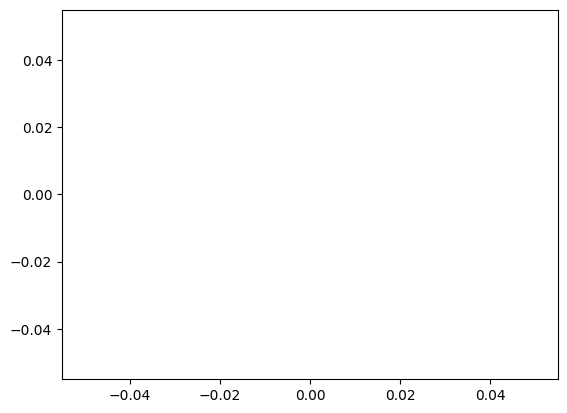

1
<class 'pandas.core.series.Series'>
person         S2 X
5401       -586.788
5402       -586.794
5403       -586.808
5404       -586.824
             ...   
5996       -589.981
5997       -589.991
5998       -590.006
5999       -590.014
group_id          1
Name: 1, Length: 601, dtype: object


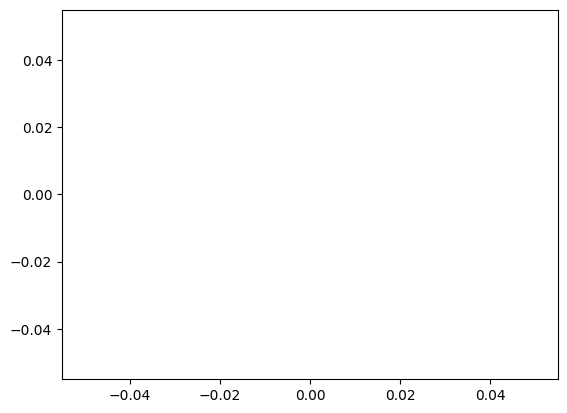

2
<class 'pandas.core.series.Series'>
person         S3 X
5401        333.003
5402        332.947
5403        332.875
5404        332.815
             ...   
5996        331.565
5997        331.568
5998        331.535
5999        331.528
group_id          1
Name: 2, Length: 601, dtype: object


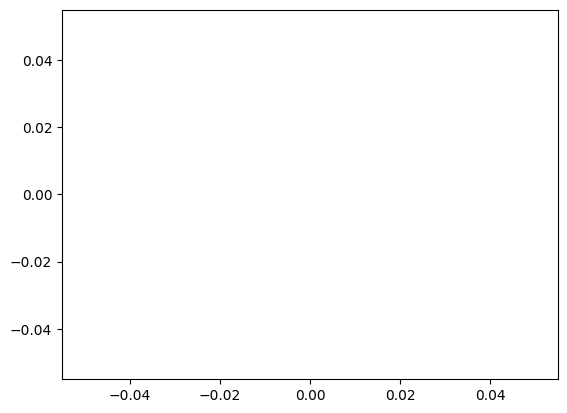

3
<class 'pandas.core.series.Series'>
person          S4 X
5401        1312.024
5402        1312.096
5403         1312.12
5404        1312.156
              ...   
5996        1310.034
5997         1310.04
5998        1310.037
5999        1310.041
group_id           1
Name: 3, Length: 601, dtype: object


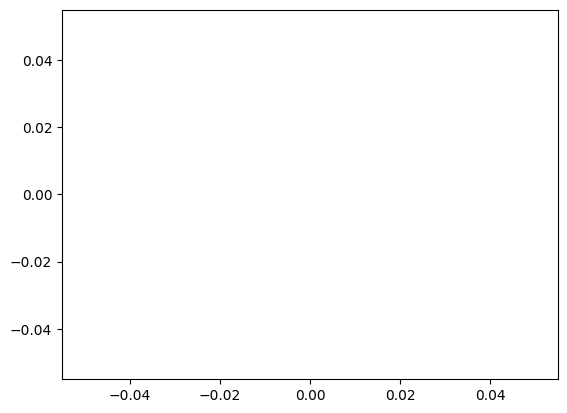

4
<class 'pandas.core.series.Series'>
person          S5 X
5401        -1182.84
5402       -1182.842
5403       -1182.857
5404       -1182.851
              ...   
5996       -1182.869
5997       -1182.825
5998       -1182.798
5999       -1182.754
group_id           1
Name: 4, Length: 601, dtype: object


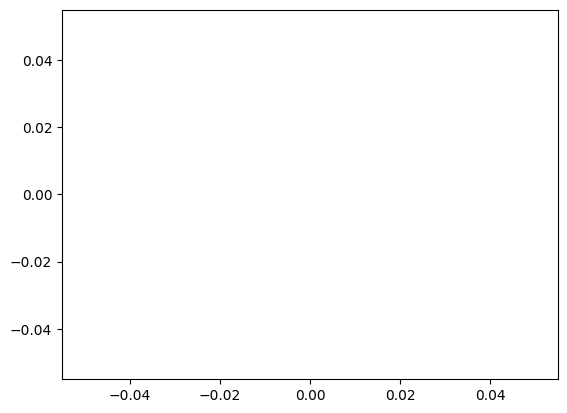

5
<class 'pandas.core.series.Series'>
person         S6 X
5401       -330.989
5402       -330.925
5403       -330.872
5404       -330.777
             ...   
5996       -335.746
5997       -335.593
5998       -335.483
5999       -335.361
group_id          1
Name: 5, Length: 601, dtype: object


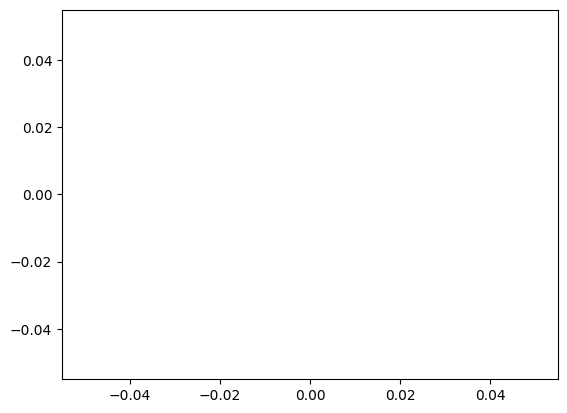

6
<class 'pandas.core.series.Series'>
person         S7 X
5401        542.766
5402        542.752
5403         542.73
5404        542.697
             ...   
5996        543.474
5997        543.513
5998        543.519
5999        543.532
group_id          1
Name: 6, Length: 601, dtype: object


In [72]:
round_counter = 0
for index, row in anomaly_data_all_1d_t.iterrows():
    print(index)
    print(type(row))
    print(row)
    if round_counter > 5:
        break
    round_counter += 1
    plt.plot(row.iloc[:1-1])
    plt.show()

0
<class 'pandas.core.series.Series'>
person          S1 X
5401       -1142.621
5402       -1142.666
5403       -1142.721
5404       -1142.761
              ...   
5996        -1135.04
5997       -1135.126
5998       -1135.225
5999       -1135.317
group_id           1
Name: 0, Length: 601, dtype: object


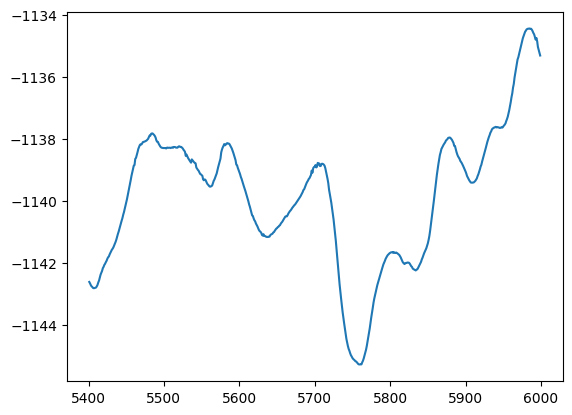

1
<class 'pandas.core.series.Series'>
person         S2 X
5401       -579.147
5402        -579.21
5403       -579.274
5404       -579.368
             ...   
5996       -581.279
5997       -581.257
5998       -581.229
5999       -581.209
group_id          1
Name: 1, Length: 601, dtype: object


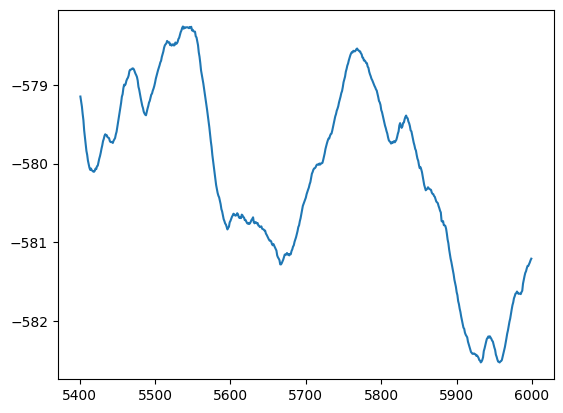

2
<class 'pandas.core.series.Series'>
person         S3 X
5401        333.943
5402        333.974
5403         334.04
5404        334.146
             ...   
5996        337.329
5997        337.352
5998        337.352
5999        337.349
group_id          1
Name: 2, Length: 601, dtype: object


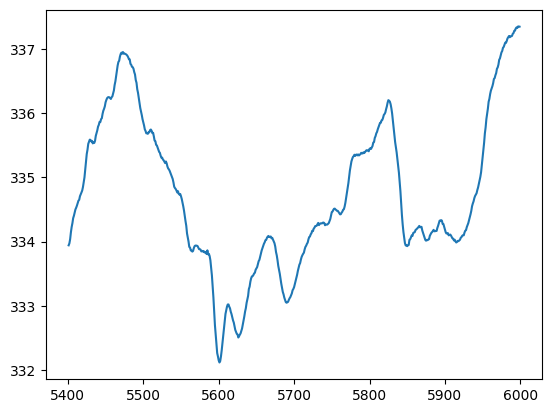

3
<class 'pandas.core.series.Series'>
person          S4 X
5401        1315.507
5402         1315.49
5403        1315.539
5404        1315.585
              ...   
5996        1312.061
5997        1312.082
5998        1312.071
5999        1312.074
group_id           1
Name: 3, Length: 601, dtype: object


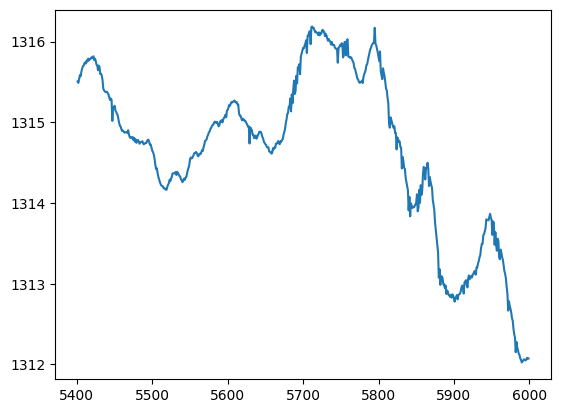

4
<class 'pandas.core.series.Series'>
person          S5 X
5401       -1185.159
5402       -1185.139
5403       -1185.101
5404       -1185.072
              ...   
5996       -1182.094
5997       -1182.065
5998       -1182.046
5999       -1182.023
group_id           1
Name: 4, Length: 601, dtype: object


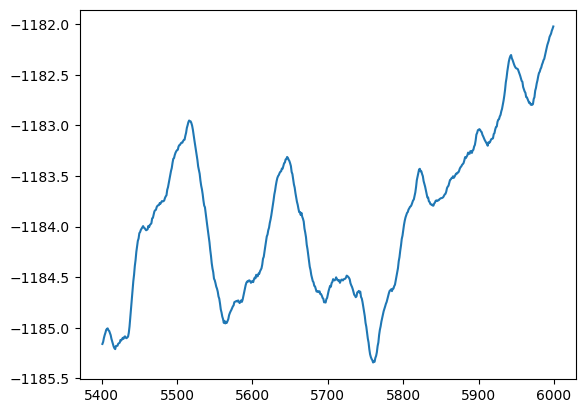

5
<class 'pandas.core.series.Series'>
person         S6 X
5401        -330.44
5402       -330.492
5403       -330.526
5404       -330.525
             ...   
5996       -328.506
5997        -328.51
5998       -328.536
5999       -328.539
group_id          1
Name: 5, Length: 601, dtype: object


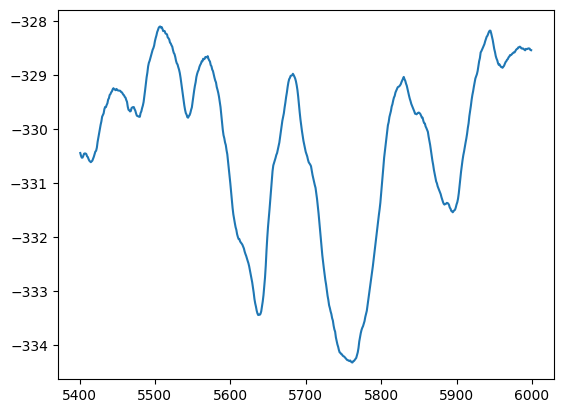

6
<class 'pandas.core.series.Series'>
person         S7 X
5401        531.505
5402          531.5
5403        531.473
5404        531.478
             ...   
5996        534.568
5997        534.615
5998        534.685
5999        534.731
group_id          1
Name: 6, Length: 601, dtype: object


In [73]:
round_counter = 0
for index, row in normal_data_all_1d_t.iterrows():
    print(index)
    print(type(row))
    print(row)
    if round_counter > 5:
        break
    round_counter += 1
    plt.plot(row.iloc[1:-1])
    plt.show()

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [74]:
normal_df = normal_data_all_1d_t.copy()
anomaly_df = anomaly_data_all_1d_t.copy()

In [75]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [76]:
train_df, val_df = train_test_split(

  normal_df,

  test_size=0.15,

  random_state=RANDOM_SEED

)

val_df, test_df = train_test_split(

  val_df,

  test_size=0.33,

  random_state=RANDOM_SEED

)

In [77]:
print(normal_data_all_1d_t.shape)
print(normal_df.shape)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(324, 601)
(324, 601)
(275, 601)
(32, 601)
(17, 601)


In [83]:
train_df.head()

,person,5401,5402,5403,5404,5405,5406,5407,5408,5409,...,5991,5992,5993,5994,5995,5996,5997,5998,5999,group_id
16,S5 X,-1187.481,-1187.438,-1187.401,-1187.363,-1187.337,-1187.279,-1187.275,-1187.223,-1187.194,...,-1188.884,-1188.905,-1188.931,-1188.935,-1188.937,-1188.964,-1188.995,-1189.018,-1189.046,1
76,S9 X,-1137.536,-1137.483,-1137.496,-1137.497,-1137.532,-1137.547,-1137.551,-1137.574,-1137.583,...,-1137.876,-1137.879,-1137.974,-1138.062,-1138.022,-1138.114,-1138.135,-1138.191,-1138.218,3
109,S8 X,1507.139,1507.102,1507.019,1506.977,1506.932,1506.881,1506.811,1506.752,1506.717,...,1507.111,1507.141,1507.147,1507.185,1507.201,1507.261,1507.278,1507.309,1507.346,4
7,S8 X,1299.785,1299.800,1299.801,1299.817,1299.834,1299.850,1299.855,1299.835,1299.853,...,1302.935,1303.036,1303.099,1303.228,1303.349,1303.466,1303.598,1303.709,1303.826,1
75,S6 X,41.691,41.711,41.711,41.675,41.678,41.671,41.667,41.637,41.615,...,42.339,42.334,42.337,42.347,42.349,42.337,42.351,42.385,42.381,3


In [256]:
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

In [198]:
def collect_time_series(df_person):
    collect_rows = []
    for index, row in df_person.iloc[:,1:-1].iterrows():
        collect_rows.extend(list(row))
        series_person_array = np.array(collect_rows)
        series_person = series_person_array.reshape(-1,1)
    return series_person

In [214]:
fitted_scalers = {}

groups = list(set(train_df.group_id))
groups
for group in groups:
    fitted_scalers[group] = {}
    #print(person)
    train_df_group = train_df[train_df.group_id == group]
    print(train_df_group.shape)
    persons = list(set(train_df_group.person))
    for person in persons:
        train_df_group_person = train_df_group[train_df_group.person == person]
        time_series_person = collect_time_series(train_df_group_person)
        tscaler_fitted = std_scaler.fit(time_series_person)
        fitted_scalers[group][person] = scaler_fitted

(32, 601)
(19, 601)
(27, 601)
(30, 601)
(28, 601)
(16, 601)
(26, 601)
(8, 601)
(31, 601)
(21, 601)
(29, 601)
(8, 601)


In [253]:
def scale_time_series(df_person, group, person, fitted_scaler):
    rows_to_stack = []
    for index, row in df_person.iloc[:,1:-1].iterrows():
        series_person_array = np.array(row)
        series_person = series_person_array.reshape(-1,1)
        sc_series = fitted_scalers[group][person].transform(series_person)
        sc_series_l = sc_series.T.tolist()
        sc_row = [person] + sc_series_l[0] + [group]
        sc_df = pd.DataFrame(columns = df_person.columns, data = [sc_row])
        rows_to_stack.append(sc_df)
    df_person_scaled = pd.concat(rows_to_stack)
    return df_person_scaled

In [254]:
frames_to_stack = []

groups = list(set(train_df.group_id))
groups
for group in groups:
    train_df_group = train_df[train_df.group_id == group]
    print(train_df_group.shape)
    persons = list(set(train_df_group.person))
    for person in persons:
        train_df_group_person = train_df_group[train_df_group.person == person]
        fitted_scaler = fitted_scalers[group][person]
        sc_train_df_group_person = scale_time_series(train_df_group_person, group, person, fitted_scaler)
        frames_to_stack.append(sc_train_df_group_person)

train_df_scaled = pd.concat(frames_to_stack)

(32, 601)
(19, 601)
(27, 601)
(30, 601)
(28, 601)
(16, 601)
(26, 601)
(8, 601)
(31, 601)
(21, 601)
(29, 601)
(8, 601)


In [255]:
print(train_df.shape)
print(train_df_scaled.shape)

(275, 601)
(275, 601)


In [257]:
frames_to_stack = []

groups = list(set(val_df.group_id))
groups
for group in groups:
    val_df_group = val_df[val_df.group_id == group]
    print(val_df_group.shape)
    persons = list(set(val_df_group.person))
    for person in persons:
        val_df_group_person = val_df_group[val_df_group.person == person]
        fitted_scaler = fitted_scalers[group][person]
        sc_val_df_group_person = scale_time_series(val_df_group_person, group, person, fitted_scaler)
        frames_to_stack.append(sc_val_df_group_person)

val_df_scaled = pd.concat(frames_to_stack)

(2, 601)
(4, 601)
(2, 601)
(4, 601)
(4, 601)
(6, 601)


KeyError: 'S6 X'

In [258]:
group

6

In [259]:
person

'S6 X'

In [260]:
fitted_scalers

{1: {'S7 X': StandardScaler(),
  'S3 X': StandardScaler(),
  'S9 X': StandardScaler(),
  'S4 X': StandardScaler(),
  'S8 X': StandardScaler(),
  'S6 X': StandardScaler(),
  'S1 X': StandardScaler(),
  'S11 X': StandardScaler(),
  'S5 X': StandardScaler(),
  'S2 X': StandardScaler(),
  'S10 X': StandardScaler(),
  'S12 X': StandardScaler()},
 2: {'S8 X': StandardScaler(),
  'S6 X': StandardScaler(),
  'S11 X': StandardScaler(),
  'S5 X': StandardScaler(),
  'S2 X': StandardScaler(),
  'S10 X': StandardScaler(),
  'S12 X': StandardScaler(),
  'S9 X': StandardScaler()},
 3: {'S3 X': StandardScaler(),
  'S4 X': StandardScaler(),
  'S6 X': StandardScaler(),
  'S1 X': StandardScaler(),
  'S11 X': StandardScaler(),
  'S5 X': StandardScaler(),
  'S2 X': StandardScaler(),
  'S10 X': StandardScaler(),
  'S12 X': StandardScaler(),
  'S9 X': StandardScaler()},
 4: {'S7 X': StandardScaler(),
  'S3 X': StandardScaler(),
  'S9 X': StandardScaler(),
  'S4 X': StandardScaler(),
  'S8 X': StandardScaler

In [117]:
from sklearn.preprocessing import StandardScaler

In [118]:
std_scaler = StandardScaler()

In [ ]:
def create_dataset(df):

  sequences = df.astype(np.float32).to_numpy().tolist()

  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]

  n_seq, seq_len, n_features = torch.stack(dataset).shape

  return dataset, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape sequence length x number of features (140x1 in our case).

Let's create some datasets:


In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_df)

val_dataset, _, _ = create_dataset(val_df)

test_normal_dataset, _, _ = create_dataset(test_df)

test_anomaly_dataset, _, _ = create_dataset(anomaly_df)

In [ ]:
type(train_dataset[0])

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
std_scaler = StandardScaler()

In [ ]:
print(len(train_dataset))
print(len(test_normal_dataset))
print(len(test_anomaly_dataset))

In [ ]:
train_dataset_standard = []
for time_series in train_dataset:
    time_series_standard = std_scaler.fit_transform(time_series)
    train_dataset_standard.append(time_series_standard)

In [ ]:
type(train_dataset[0])

In [ ]:
n_features

In [ ]:
seq_len

In [ ]:
type(train_dataset)

In [ ]:
len(train_dataset)

In [ ]:
type(train_dataset[0])

In [ ]:
train_dataset[0].shape

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)
*Sample Autoencoder Architecture [Image Source](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)*

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [ ]:
sequences = train_df.astype(np.float32).to_numpy().tolist()

In [ ]:
type(sequences)

In [ ]:
len(sequences)

In [ ]:
type(sequences[0])

In [ ]:
len(sequences[0])

In [ ]:
len(train_dataset)

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features

    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(

      input_size=n_features,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=self.hidden_dim,

      hidden_size=embedding_dim,

      num_layers=1,

      batch_first=True

    )

  def forward(self, x):

    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)

    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))


The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):

    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim

    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(

      input_size=input_dim,

      hidden_size=input_dim,

      num_layers=1,

      batch_first=True

    )

    self.rnn2 = nn.LSTM(

      input_size=input_dim,

      hidden_size=self.hidden_dim,

      num_layers=1,

      batch_first=True

    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):

    x = x.repeat(self.seq_len, self.n_features)

    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)

    x, (hidden_n, cell_n) = self.rnn2(x)

    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):

    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)

    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):

    x = self.encoder(x)

    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)

model = model.to(device)

In [ ]:
model

## Training

Let's write a helper function for our training process:

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

  criterion = nn.L1Loss(reduction='sum').to(device)

  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())

  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):

    model = model.train()

    train_losses = []

    for seq_true in train_dataset:

      optimizer.zero_grad()

      seq_true = seq_true.to(device)
      #print('seq_true:')  
      #print(seq_true[0:10])  

      seq_pred = model(seq_true)
      #print('seq_pred:')
      #print(seq_pred[0:10])  

      loss = criterion(seq_pred, seq_true)

      loss.backward()

      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []

    model = model.eval()

    with torch.no_grad():

      for seq_true in val_dataset:

        seq_true = seq_true.to(device)

        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)

        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)

    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)

    history['val'].append(val_loss)

    if val_loss < best_loss:

      best_loss = val_loss

      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)

  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the L1Loss, which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:


In [ ]:
model, history = train_model(

  model,

  train_dataset,

  val_dataset,

  n_epochs=70

)

In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

In [ ]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

In [ ]:
def predict(model, dataset):

  predictions, losses = [], []

  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():

    model = model.eval()

    for seq_true in dataset:

      seq_true = seq_true.to(device)

      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())

      losses.append(loss.item())

  return predictions, losses

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

In [ ]:
_, losses = predict(model, train_dataset)

sns.distplot(losses, bins=50, kde=True);

In [ ]:
THRESHOLD = 1000000

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

In [ ]:
predictions, pred_losses = predict(model, test_normal_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_dataset)}')

### Anomalies
We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [ ]:
len(test_anomaly_dataset)

In [ ]:
len(test_normal_dataset)

In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

Now we can take the predictions of our model for the subset of anomalies:

In [ ]:
predictions, pred_losses = predict(model, anomaly_dataset)
sns.distplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_dataset)}')

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_normal_dataset[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(test_anomaly_dataset[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)